In [29]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
!pip install eli5
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import roc_curve, auc
import numpy as np
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
#Loading c_final.csv
df = pd.read_csv('complaintsclean.csv', nrows = 500000)
df.head()

,issue,complaint
0,Problem with a credit reporting company's inve...,week ago send letter 3 credit bureau regard it...
1,Problem with a credit reporting company's inve...,submit several dispute follow credit report ag...
2,Improper use of your report,accordance Fair Credit Reporting act List acco...
3,Problem with a credit reporting company's inve...,account meeting FCRA requirement multiple viol...
4,Problem with a credit reporting company's inve...,Despite multiple write request unverified item...


In [31]:
df.shape

(500000, 2)

In [32]:
pd.set_option("display.max_rows", None)
issue_counts = df['issue'].value_counts()
issue_counts

Incorrect information on your report                                                131338
Problem with a credit reporting company's investigation into an existing problem     98926
Improper use of your report                                                          75339
Attempts to collect debt not owed                                                    31388
Managing an account                                                                  15994
Trouble during payment process                                                       12437
Written notification about debt                                                      11728
Problem with a purchase shown on your statement                                       9596
Took or threatened to take negative or legal action                                   6658
False statements or representation                                                    6465
Struggling to pay mortgage                                                            5910

In [33]:
issue_counts = df['issue'].value_counts()
miscellaneous_issues = issue_counts[issue_counts < 100].index.tolist()
df.loc[df['issue'].isin(miscellaneous_issues), 'issue'] = 'miscellaneous'
issue_counts_updated = df['issue'].value_counts()
issue_counts_updated

Incorrect information on your report                                                131338
Problem with a credit reporting company's investigation into an existing problem     98926
Improper use of your report                                                          75339
Attempts to collect debt not owed                                                    31388
Managing an account                                                                  15994
Trouble during payment process                                                       12437
Written notification about debt                                                      11728
Problem with a purchase shown on your statement                                       9596
Took or threatened to take negative or legal action                                   6658
False statements or representation                                                    6465
Struggling to pay mortgage                                                            5910

In [36]:
df = df.dropna(subset=['complaint'])


In [37]:
#TF-IDF
tfidf = TfidfVectorizer(stop_words=stop)
X = tfidf.fit_transform(df['complaint'])
y = df['issue']
print(X.shape)
print(y.shape)

(499972, 131740)
(499972,)


In [38]:
# Split data and create stratified train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(399977, 131740) (99995, 131740) (399977,) (99995,)


In [39]:
# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy of logistic regression classifier on test set: 0.64


In [40]:
# Linear SVC
lsvc = LinearSVC()
lsvc.fit(X_train, y_train)
y_pred = lsvc.predict(X_test)
print('Accuracy of linear SVC classifier on test set: {:.2f}'.format(lsvc.score(X_test, y_test)))

Accuracy of linear SVC classifier on test set: 0.65


In [41]:
# Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)
print('Accuracy of Naive Bayes classifier on test set: {:.2f}'.format(nb.score(X_test, y_test)))

Accuracy of Naive Bayes classifier on test set: 0.47


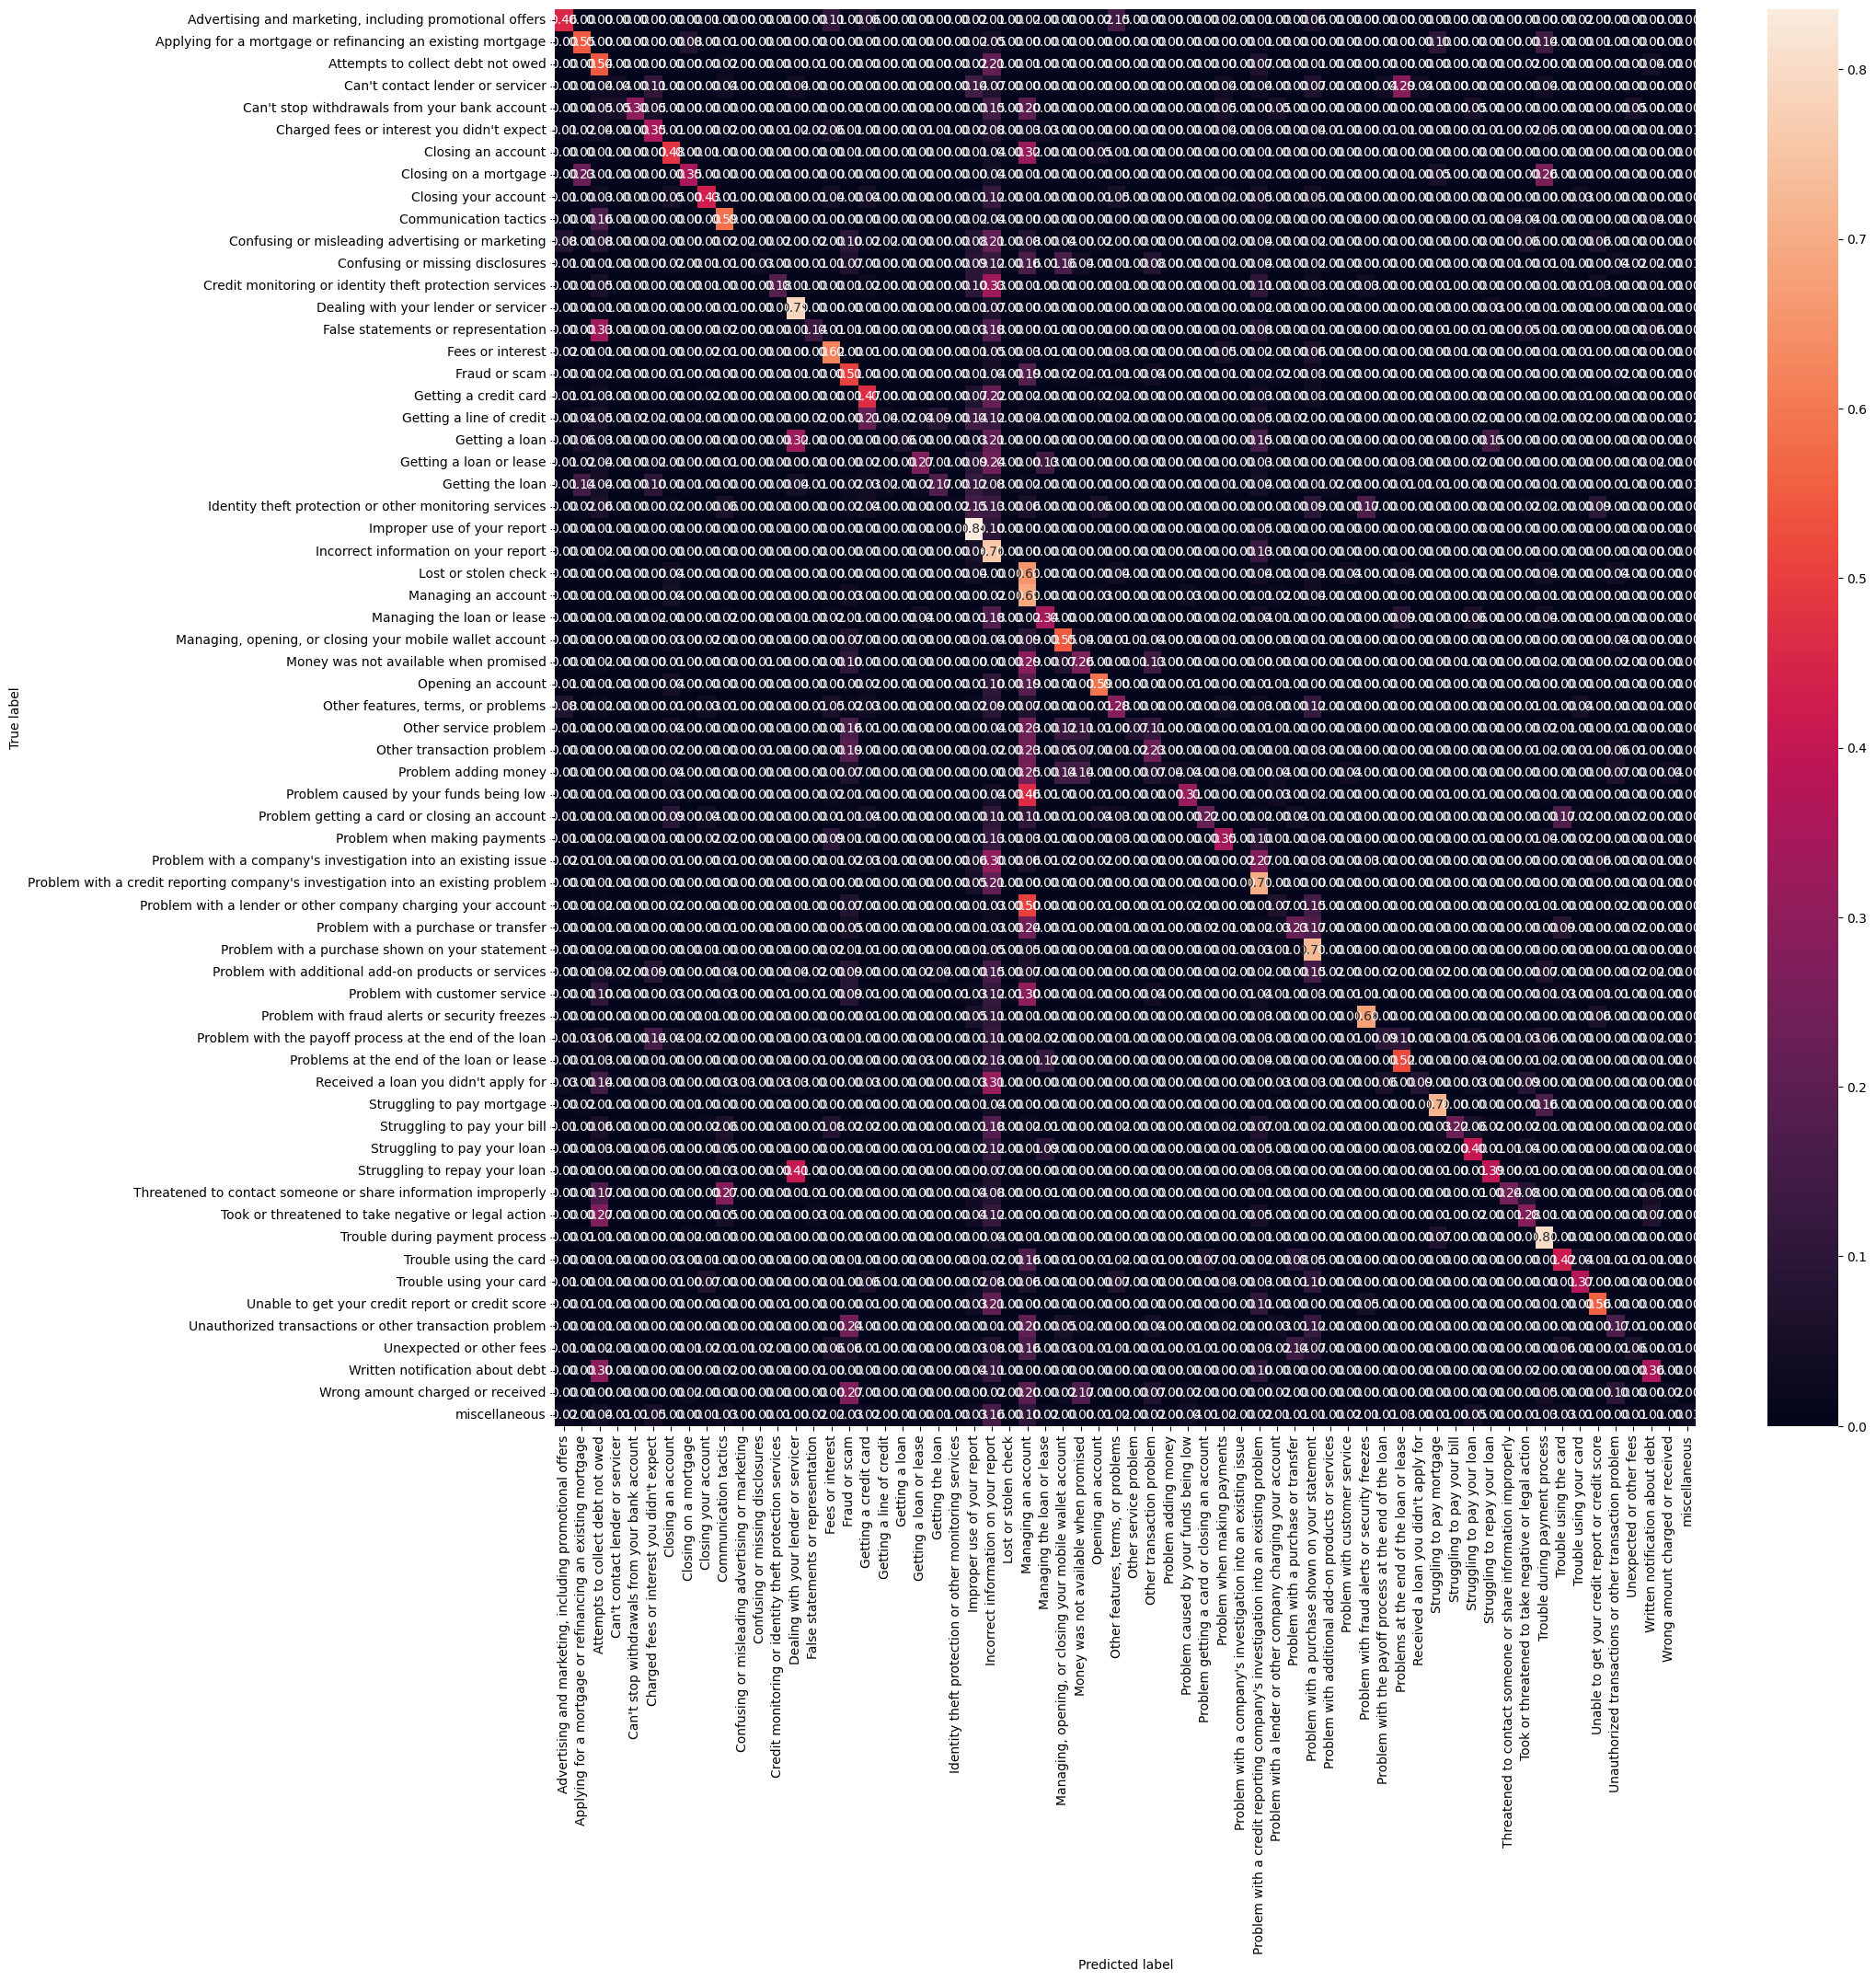

In [42]:
# Confusion Matrix
labels = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(20,20))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=labels, yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

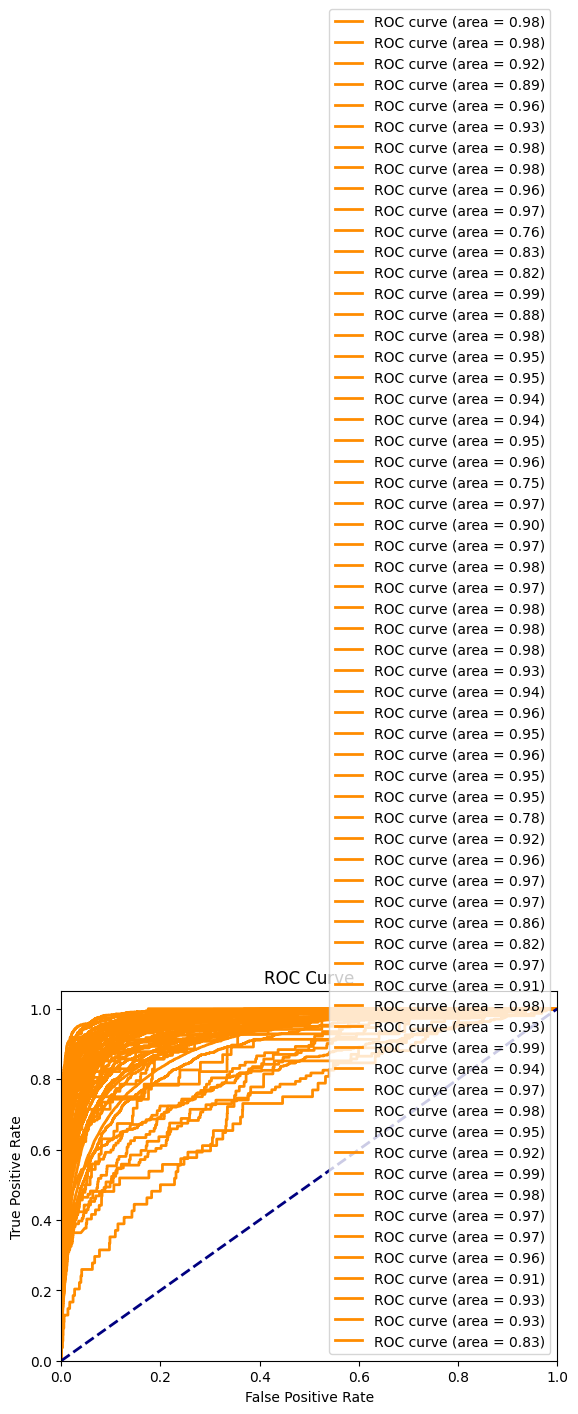

In [43]:
# ROC Curve
y_score = lsvc.decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(y_test, y_score[:, i], pos_label=labels[i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
lw = 2
for i in range(len(labels)):
    plt.plot(fpr[i], tpr[i], color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [44]:
#Visualizing the most common words
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                            background_color='white',
                            stopwords=stopwords,
                            max_words=200,
                            max_font_size=40,
                            random_state=42
                            ).generate(str(df['complaint']))
print(wordcloud)

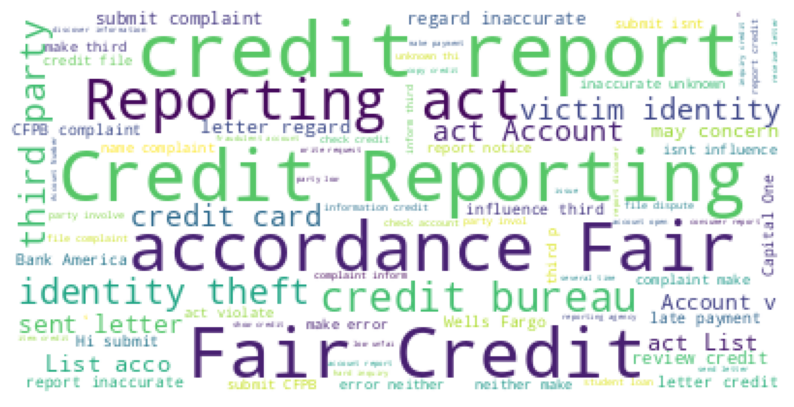

In [45]:
# Plotting the wordcloud
fig = plt.figure(1, figsize=(10,10))
plt.axis('off')
plt.imshow(wordcloud)
plt.show()

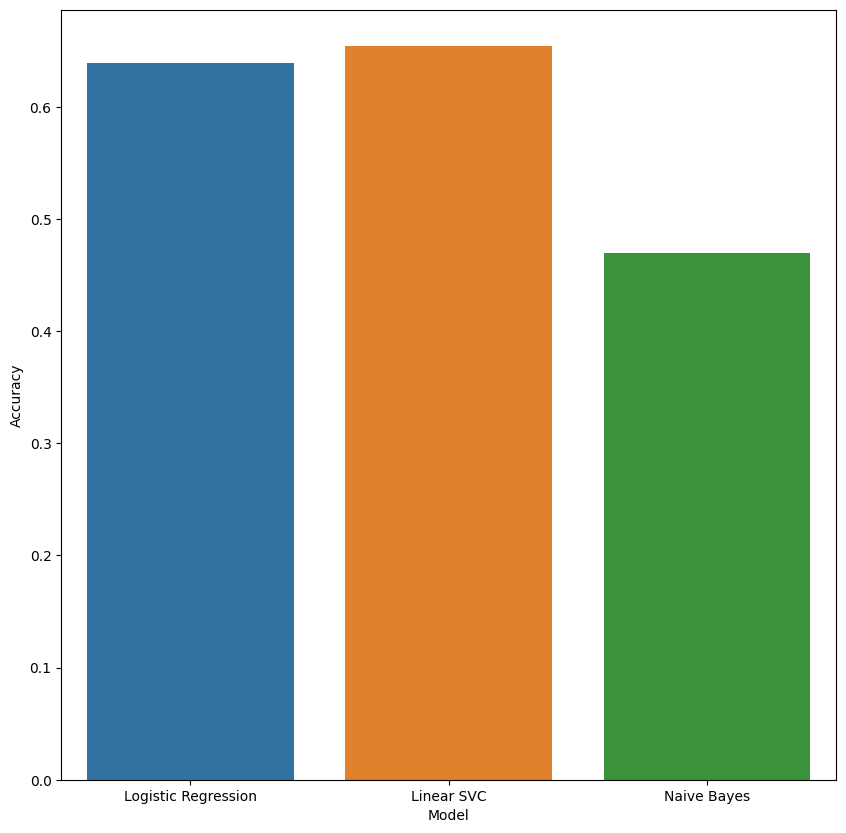

In [46]:
# Bar plot of accuracy scores
models = ['Logistic Regression', 'Linear SVC', 'Naive Bayes']
scores = [logreg.score(X_test, y_test), lsvc.score(X_test, y_test), nb.score(X_test, y_test)]
plt.figure(figsize=(10,10))
sns.barplot(x=models, y=scores)
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.show()

In [ ]:
# Save to csv
df.to_csv('complaintstfidf.csv', index=False)